## 1. Loading data

We start by importing the libraries we need: 
- sklearn and numpy to do machine learning, 
- csv and pickle read the data and write out submission and model files, 
- time and os to keep organized with the files we output,
- matplotlib to perform visualizations.
We also import some specific sklearn components as well as an utils library with some handy extra functions.

In [5]:
import sklearn
import numpy as np
import csv
import pickle
import time
import os
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV

import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))


from utils_general import utils_for_students

In [6]:
train_samples = utils_for_students.load_dataset_stage2('../data/stage2_labels_train.csv', 'train')
test_samples = utils_for_students.load_dataset_stage2('../data/stage2_ids_test.csv', 'test')

In [7]:
train_samples[0].keys()

dict_keys(['path', 'id', 'label', 'signer'])

In order to get a better grasp of every class in the dataset, we provide some additional information here.

There are 15 different classes. Each class corresponds to a sign. Signs can be annotated using sign glosses, which are representations of signs in written form in a spoken language. In the below table, we list all glosses, the English meaning of the corresponding sign, and provide a link to the Flemish sign language dictionary so that you can see an example performance of that sign.

| Gloss             | English meaning | Dictionary URL                                                                                        |
|-------------------|-----------------|-------------------------------------------------------------------------------------------------------|
| c.AF              | Done, finished  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AF/AF-B-209.mp4          |
| c.OOK             | Too, also       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/OO/OOK-A-8491.mp4        |
| ZELFDE-A          | The same        | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/ZE/ZELFDE-A-14290.mp4    |
| AUTO-RIJDEN-A     | To drive a car  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/RI/RIJDEN-C-9982.mp4     |
| HEBBEN-A          | To have         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HE/HEBBEN-A-4801.mp4     |
| HAAS-oor          | Hare            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HA/HAAS-B-16147.mp4      |
| AANKOMEN-A        | To arrive       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AA/AANKOMEN-A-39.mp4     |
| SCHILDPAD-Bhanden | Turtle          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/SC/SCHILDPAD-A-10503.mp4 |
| WAT-A             | What            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/WA/WAT-A-13657.mp4       |
| c.ZIEN            | To see          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/BE/BEKIJKEN-A-1157.mp4   |
| NAAR-A            | Towards         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GA/GA-NAAR-A-4032.mp4    |
| MOETEN-A          | To must         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/MO/MOETEN-D-17652.mp4    |
| C: 1              | 1               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/1-/1-A-15277.mp4         |
| GOED-A            | Good            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GO/GOED-C-4413.mp4       |
| C: 2              | 2               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/2-/2-A-15278.mp4         |

In [25]:
from utils_feature_preprocessing.transform_frames import transform_to_k_frames, frames_to_features
from utils_feature_preprocessing.correct_zero_values import correct_zeros
from utils_feature_preprocessing.enlarge_hands import enlarge_hands
from utils_feature_preprocessing.features_from_hand import extract_finger_distances,extract_average_hands
from utils_feature_preprocessing.remove_face import remove_face,remove_face_and_hands

def transform_frames(pose_sequence, k=2):
    #pose_sequence = correct_zeros(pose_sequence)
    pose_sequence = transform_to_k_frames(pose_sequence, k=k)
    pose_sequence = enlarge_hands(pose_sequence, scale_factor=1)
    return pose_sequence

In [36]:
# Concatenate the training set features.
X_train = []
y_train = []

K = 4
frames_per_sample = []

for sample in train_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('../data/stage2/train/', sample['path']))
    frames_per_sample.append(len(pose_sequence))
    X_train.append(transform_frames(pose_sequence, K))
    y_train.append(sample['label'])
    
# Encode the labels as integers
label_encoder = utils_for_students.label_encoder()
y_train = label_encoder.transform(y_train)


Showing 66 labels of class C: 1
(66, 4, 125, 3)
[12  4  7  2  7 11  8  7  6  9 10  3  6 12  5  8  7  7  5  4 10 14 54 14
  5  4  6  4  6  8  4  5 14  7  7  4  3  6  6  4  5  5  4  3  2 33  6  4
  8  6  5 58 11 35  4  4 15  3 11  8  6  5  5 21 11 13]


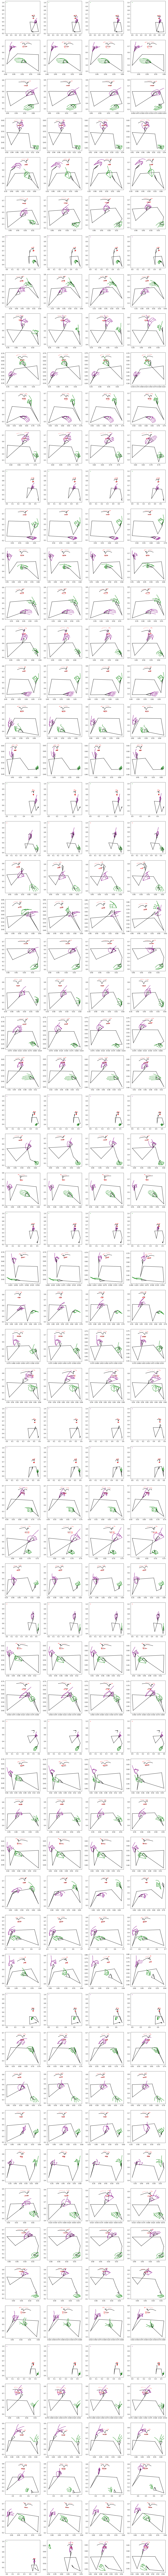

In [37]:
from utils_general.utils_for_students import label_encoder

CLASSES = label_encoder().inverse_transform([i for i in range(len(label_encoder().classes_))])
LABEL = 2

# Extract for specific label
sample_indices, = np.where(y_train == LABEL)
samples = np.array(X_train)[sample_indices] 
frames_per_sample_of_label = np.array(frames_per_sample)[sample_indices] 

print("Showing",len(samples),"labels of class",CLASSES[LABEL])
print(samples.shape)
print(frames_per_sample_of_label)

sample_count = len(samples)
frame_count = K
fig, axs = plt.subplots(sample_count, frame_count, figsize=(5*frame_count,5*sample_count))
for sample_index in range(sample_count):
    for frame_index in range(frame_count):
        axis = axs[sample_index, frame_index]
        utils_for_students.visualize_pose(samples[sample_index][frame_index], axis)
        
        


### Class histogram

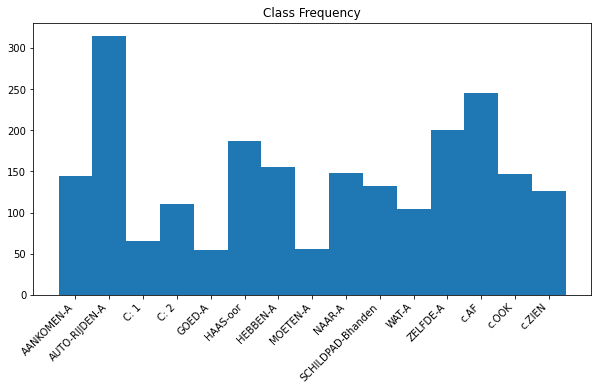

In [27]:
from matplotlib import pyplot as plt
import pandas as pd

plt.figure(figsize = (10,5))
data_class = pd.DataFrame(label_encoder().inverse_transform(y_train))
unique, counts = np.unique(data_class, return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()